In [14]:
!pip install geopy
!pip install folium
!pip install bs4
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import folium
from folium import plugins

import seaborn as sns
import matplotlib.pyplot as plt 
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

from sklearn.cluster import KMeans 

print("libraries imported")

libraries imported


## Part 1 - Webscraping, Data Wrangling, and Cleaning


In [73]:
url = 'https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canada:_M&oldid=1011037969' 

data = requests.get(url).text 

In [74]:
w_soup = BeautifulSoup(data, 'html5lib')

In [75]:
# Scrape the table in the Wikipedia page for the PostalCode, Borough, and Neighborhood

# Setup lists for postal_code, borough, and neighborhood
post_list = []
boro_list = []
neighb_list = []

tab_bodies = w_soup.find_all('tbody')

tab_data = tab_bodies[0]

for i, row in enumerate(tab_data.find_all('tr')):
    if i == 0:
        headers = row.find_all('th')
        postal_header = headers[0].getText().strip()
        borough_header = headers[1].getText().strip()
        neighborhood_header = headers[2].getText().strip()
    else:
        cols = row.find_all('td')
        postal_code = cols[0].getText()
        borough = cols[1].getText()
        neighborhood = cols[2].getText()
        
        post_list.append(postal_code.strip())
        boro_list.append(borough.strip())
        neighb_list.append(neighborhood.strip())

In [76]:
# Create pandas dataframe containing postal_code, borough, neighborhood information

toronto_data = {postal_header : post_list,
               borough_header : boro_list,
               neighborhood_header : neighb_list}

tor_df = pd.DataFrame(toronto_data)
tor_df.head()

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [77]:
# Replace 'Not assigned' to NaN
tor_df['Borough'].replace('Not assigned', np.nan, inplace = True)
tor_df.shape

(180, 3)

In [78]:
# Drop cells with NaN

tor_df.dropna(subset = ['Borough'], axis = 0, inplace = True)

In [79]:
# Sort the dataframe by postal code 
tor_df.sort_values(by=['Postal Code'], inplace = True)
tor_df.reset_index(drop = True, inplace=True)
tor_df.head()

,Postal Code,Borough,Neighbourhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [80]:
tor_df.shape

(103, 3)

In [81]:
## Part 2 - Adding Coordinate Data

In [82]:
# read coordinate data into a pandas dataframe
filename = 'https://cocl.us/Geospatial_data'
coord_data = pd.read_csv(filename)

# merge the toronto dataframe with the coordinates based on Postal Code
toronto_df = pd.merge(tor_df, coord_data, on = 'Postal Code')
toronto_df.rename(columns={'Neighbourhood': 'Neighborhood'}, inplace = True)
toronto_df.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [83]:
# Latitude and Longitude coordinates for Toronto

TOR_LAT = 43.65
TOR_LONG = - 79.38

In [84]:
# Plot map of neighborhoods in toronto

toronto_map = folium.Map(location = [TOR_LAT, TOR_LONG], zoom_start =11)

mark_cluster = plugins.MarkerCluster().add_to(toronto_map)

for lat, long, label in zip(toronto_df.Latitude, toronto_df.Longitude, toronto_df.Neighborhood):
    folium.features.CircleMarker([lat, long],
                                radius = 7,
                                color = 'red',
                                fill = True,
                                popup = folium.Popup(label, parse_html = True)).add_to(mark_cluster)

toronto_map

In [85]:
# Count of all the different boroughs in Toronto
toronto_df['Borough'].value_counts()

North York          24
Downtown Toronto    19
Scarborough         17
Etobicoke           12
Central Toronto      9
West Toronto         6
East York            5
East Toronto         5
York                 4
Toronto/York         1
Mississauga          1
Name: Borough, dtype: int64

In [86]:
## Part 3 Finding Top Venues in each Neighborhood using the Foursquare API

In [87]:
# create dataframe for venues in each neighborhood
city_venues_df = pd.DataFrame(columns=['venue_name', 'category', 'venue_lat', 'venue_long', 'neighborhood', 'neighb_lat', 'neighb_long'])
city_venues_df

,venue_name,category,venue_lat,venue_long,neighborhood,neighb_lat,neighb_long


In [88]:
# make a tuple of latitude and longitude coordinates for each neighborhood in toronto_df
neighb_coord = []

for neighb, n_lat, n_long in zip(toronto_df.Neighborhood, toronto_df.Latitude, toronto_df.Longitude):
    neighb_coord.append((neighb, n_lat, n_long))
    
neighb_coord[0:4]

[('Malvern, Rouge', 43.806686299999996, -79.19435340000001),
 ('Rouge Hill, Port Union, Highland Creek', 43.7845351, -79.16049709999999),
 ('Guildwood, Morningside, West Hill', 43.7635726, -79.1887115),
 ('Woburn', 43.7709921, -79.21691740000001)]

In [89]:
###### Making Calls to the Foursquare API

In [90]:
# Credentials were removed -- requests to API won't work without it
CLIENT_ID = 'IOQ0N5D1HIFGKMMIWKESME5CAITQO2KK0DL4Y5PCH1OYLJFV' # Foursquare ID
CLIENT_SECRET = 'XNSVDLVBGX1KJKX0XVOEK5GMFGKPG0GZWO2W55RZGZUKYNAK'
#ACCESS_TOKEN = ''
ACCESS_TOKEN = 'SREOL4OTBJRSLBWW3ZSYGYFQVGPZ2N1H3IEOQYBXXJWKXSOP'
VERSION = '20180604' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value
RADIUS = 500

In [91]:
# loop through each place neighborhood and make a call to the API for the top 100 venues within 500 meters of the neighborhood 

venues_list = []

for index, location in enumerate(neighb_coord):
    neighb_lat = neighb_coord[index][1]
    neighb_long = neighb_coord[index][2]

    try:
        url = 'https://api.foursquare.com/v2/venues/explore?oauth_token={}&v={}&ll={},{}&radius={}&limit={}'.format(ACCESS_TOKEN,
                                                                                                                VERSION,
                                                                                                                neighb_lat,
                                                                                                                neighb_long,
                                                                                                                RADIUS,
                                                                                                                LIMIT)
        venues_data = requests.get(url).json()
        venues = venues_data['response']['groups'][0]['items']
        print(neighb_coord[index][0])
    
        for venue in venues:
            venues_list.append((venue['venue']['name'],
                              venue['venue']['categories'][0]['name'],
                              venue['venue']['location']['lat'],
                              venue['venue']['location']['lng'],
                               neighb_coord[index][0],
                               neighb_coord[index][1],
                               neighb_coord[index][2]))
            
    except:
        print("Current neighborhood", neighb_coord[index][0],neighb_lat, neighb_long)

print("\n--All done--")

Malvern, Rouge
Rouge Hill, Port Union, Highland Creek
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
Kennedy Park, Ionview, East Birchmount Park
Golden Mile, Clairlea, Oakridge
Cliffside, Cliffcrest, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Wexford Heights, Scarborough Town Centre
Wexford, Maryvale
Agincourt
Clarks Corners, Tam O'Shanter, Sullivan
Milliken, Agincourt North, Steeles East, L'Amoreaux East
Steeles West, L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
York Mills, Silver Hills
Willowdale, Newtonbrook
Willowdale, Willowdale East
York Mills West
Willowdale, Willowdale West
Parkwoods
Don Mills
Don Mills
Bathurst Manor, Wilson Heights, Downsview North
Northwood Park, York University
Downsview
Downsview
Downsview
Downsview
Current neighborhood Victoria Village 43.725882299999995 -79.31557159999998
Parkview Hill, Woodbine Gardens
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East T

In [92]:
# create dataframe for venues in each neighborhood
city_venues_df = pd.DataFrame(venues_list, columns=['venue_name', 'category', 'venue_lat', 'venue_long', 'neighborhood', 'neighb_lat', 'neighb_long'])
city_venues_df

print(city_venues_df.shape)
city_venues_df.head()

(3062, 7)


,venue_name,category,venue_lat,venue_long,neighborhood,neighb_lat,neighb_long
0,Wendy’s,Fast Food Restaurant,43.807448,-79.199056,"Malvern, Rouge",43.806686,-79.194353
1,NT Home Service Inc.,Home Service,43.806411,-79.197736,"Malvern, Rouge",43.806686,-79.194353
2,RIGHT WAY TO GOLF,Golf Course,43.785177,-79.161108,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
3,Chris Effects Painting,Construction & Landscaping,43.784343,-79.163742,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
4,Great Shine Window Cleaning,Home Service,43.783145,-79.157431,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497


In [93]:
# save to csv to use later 
city_venues_df.to_csv('all_venue_data.csv', index=False)

In [94]:
# read all_venue_data.csv
city_venues_df = pd.read_csv('all_venue_data.csv')
city_venues_df.head()

,venue_name,category,venue_lat,venue_long,neighborhood,neighb_lat,neighb_long
0,Wendy’s,Fast Food Restaurant,43.807448,-79.199056,"Malvern, Rouge",43.806686,-79.194353
1,NT Home Service Inc.,Home Service,43.806411,-79.197736,"Malvern, Rouge",43.806686,-79.194353
2,RIGHT WAY TO GOLF,Golf Course,43.785177,-79.161108,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
3,Chris Effects Painting,Construction & Landscaping,43.784343,-79.163742,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
4,Great Shine Window Cleaning,Home Service,43.783145,-79.157431,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497


In [95]:
"There are {} unique categories".format(len(city_venues_df['category'].unique()))

'There are 318 unique categories'

In [96]:
# One-hot-encoding for each venue category 
city_dummies = pd.get_dummies(city_venues_df[['category']], prefix='', prefix_sep='')

city_dummies.insert(0, "Neighb_Name", city_venues_df['neighborhood'])

city_dummies.shape

(3062, 319)

In [97]:
# The dataframe will be grouped by neighborhood and mean of each category will be taken

neighb_grouped = city_dummies.groupby("Neighb_Name").mean().reset_index()

print(neighb_grouped.shape)
neighb_grouped.head()

(97, 319)


,Neighb_Name,ATM,Accessories Store,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Watch Shop,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,Bayview Village,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,"Bedford Park, Lawrence Manor East",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.019231,0.0


In [99]:
num_top_venues = 10

for hood in neighb_grouped['Neighb_Name']:
    print("**"+hood+"**")
    temp = neighb_grouped[neighb_grouped['Neighb_Name'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

**Agincourt**
                       venue  freq
0  Latin American Restaurant  0.14
1             Hardware Store  0.14
2            Fireworks Store  0.14
3               Skating Rink  0.14
4                     Lounge  0.14
5             Clothing Store  0.14
6             Breakfast Spot  0.14
7     Peking Duck Restaurant  0.00
8                Pastry Shop  0.00
9                Music Venue  0.00


**Alderwood, Long Branch**
                venue  freq
0         Pizza Place  0.17
1                 Pub  0.08
2        Skating Rink  0.08
3      Sandwich Place  0.08
4  Athletics & Sports  0.08
5         Coffee Shop  0.08
6                 Gym  0.08
7            Pharmacy  0.08
8          Playground  0.08
9        Dance Studio  0.08


**Bathurst Manor, Wilson Heights, Downsview North**
                venue  freq
0            Pharmacy  0.06
1   Mobile Phone Shop  0.06
2      Ice Cream Shop  0.06
3                 Spa  0.06
4         Coffee Shop  0.06
5                Bank  0.06
6    Sushi Res

In [100]:
# number of venues to rank
top_x = 10

# create empty list for dataframe column names
column_names = []

for i in np.arange(0, top_x):
    column_names.append("Venue Rank {}".format(i+1))

# create a new dataframe that contains the most frequently appearing venues in each neighborhood
ranked_venues = pd.DataFrame(columns = column_names)
ranked_venues.insert(0, 'Neighborhood', neighb_grouped['Neighb_Name'])

ranked_venues.head()

,Neighborhood,Venue Rank 1,Venue Rank 2,Venue Rank 3,Venue Rank 4,Venue Rank 5,Venue Rank 6,Venue Rank 7,Venue Rank 8,Venue Rank 9,Venue Rank 10
0,Agincourt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"Alderwood, Long Branch",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"Bathurst Manor, Wilson Heights, Downsview North",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Bayview Village,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"Bedford Park, Lawrence Manor East",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [101]:

def most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [102]:
for ind in neighb_grouped.index:
    ranked_venues.iloc[ind, 1:] = most_common_venues(neighb_grouped.iloc[ind, :], top_x)
    
ranked_venues.head()

,Neighborhood,Venue Rank 1,Venue Rank 2,Venue Rank 3,Venue Rank 4,Venue Rank 5,Venue Rank 6,Venue Rank 7,Venue Rank 8,Venue Rank 9,Venue Rank 10
0,Agincourt,Fireworks Store,Hardware Store,Latin American Restaurant,Clothing Store,Skating Rink,Lounge,Breakfast Spot,Fast Food Restaurant,Field,Farmers Market
1,"Alderwood, Long Branch",Pizza Place,Gym,Pool,Dance Studio,Pharmacy,Sandwich Place,Skating Rink,Playground,Pub,Coffee Shop
2,"Bathurst Manor, Wilson Heights, Downsview North",Mobile Phone Shop,Pharmacy,Coffee Shop,Spa,Ice Cream Shop,Bank,Sandwich Place,Fried Chicken Joint,Sushi Restaurant,Supermarket
3,Bayview Village,Gym,Bank,Chinese Restaurant,Spa,Japanese Restaurant,Café,Event Space,Eastern European Restaurant,Electronics Store,Empanada Restaurant
4,"Bedford Park, Lawrence Manor East",Spa,Italian Restaurant,Pizza Place,Sandwich Place,Juice Bar,Boutique,Coffee Shop,Massage Studio,Business Service,Sushi Restaurant


In [103]:

## Part 4 - Clustering Neighborhoods

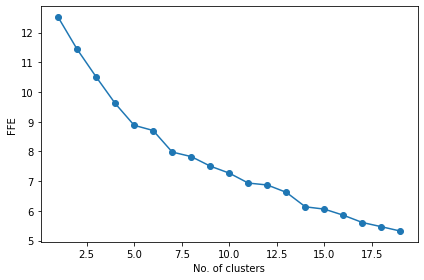

In [104]:
# Determine the optimal number of clusters to use in model using 'elbow method, 
# drop column with neighborhood names 
neighb_clusters = neighb_grouped.drop('Neighb_Name', axis=1)

X = neighb_clusters

ffe = []
for i in range(1, 20):
    km = KMeans(n_clusters=i, 
                init='k-means++', 
                n_init=10, 
                max_iter=300, 
                random_state=0)
    km.fit(X)
    ffe.append(km.inertia_)
    
# plot the distortion for number of clusters   
plt.plot(range(1, 20), ffe, marker='o')
plt.xlabel('No. of clusters')
plt.ylabel('FFE')
plt.tight_layout()
plt.show()

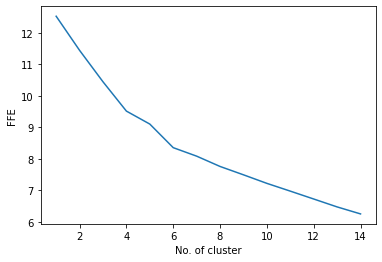

In [105]:
neighb_clusters = neighb_grouped.drop('Neighb_Name', axis=1)
ffe = {}
for k in range(1, 15):
    kmeans = KMeans(n_clusters=k).fit(neighb_clusters)
    neighb_clusters["clusters"] = kmeans.labels_
    #print(data["clusters"])
    ffe[k] = kmeans.inertia_  

plt.figure()
plt.plot(list(ffe.keys()), list(ffe.values()))
plt.xlabel("No. of cluster")
plt.ylabel("FFE")
plt.show()

In [106]:
X=neighb_clusters

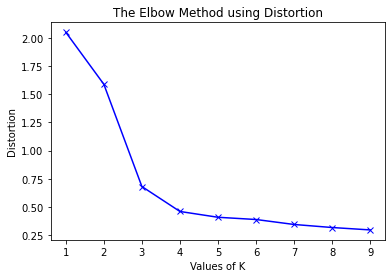

In [107]:
from scipy.spatial.distance import cdist
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
 
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

In [108]:
k_clusters = 7

neighb_clusters = neighb_grouped.drop('Neighb_Name', axis=1)
k_means = KMeans(n_clusters = k_clusters).fit(neighb_clusters)
k_labels = k_means.labels_

if 'Cluster Labels' in ranked_venues.columns:
    ranked_venues.drop(['Cluster Labels'], axis = 1, inplace = True)

ranked_venues.insert(0, 'Cluster Labels', k_labels)
toronto_merged = toronto_df
toronto_merged = pd.merge(left = toronto_merged, right = ranked_venues, on ='Neighborhood')

print(toronto_merged.shape)
toronto_merged.head()

(101, 16)


,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,Venue Rank 1,Venue Rank 2,Venue Rank 3,Venue Rank 4,Venue Rank 5,Venue Rank 6,Venue Rank 7,Venue Rank 8,Venue Rank 9,Venue Rank 10
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353,6,Home Service,Fast Food Restaurant,Fabric Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Escape Room,Ethiopian Restaurant,Event Space
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,6,Construction & Landscaping,Golf Course,Moving Target,Home Service,Creperie,Cuban Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Cosmetics Shop
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,3,Electronics Store,Breakfast Spot,Intersection,Donut Shop,Medical Center,Restaurant,Rental Car Location,Bank,Mexican Restaurant,Spa
3,M1G,Scarborough,Woburn,43.770992,-79.216917,3,Coffee Shop,Insurance Office,Other Repair Shop,Yoga Studio,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Escape Room,Ethiopian Restaurant
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,3,Caribbean Restaurant,Bakery,Gas Station,Burger Joint,Hakka Restaurant,Spa,Athletics & Sports,Gym,Thai Restaurant,Lounge


In [109]:
cluster_map = folium.Map(location =[TOR_LAT, TOR_LONG], zoom_start = 11)

x = np.arange(k_clusters)
ys = [i + x + (i*x)**2 for i in range(k_clusters)]
colors_array = cm.jet(np.linspace(0, 1, len(ys)))
rrr = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, neighb, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(neighb) + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=6,
        popup=label,
        color=rrr[cluster-1],
        fill=True,
        fill_color=rrr[cluster-1],
        fill_opacity=0.7).add_to(cluster_map)
       
cluster_map